In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from pyimagesearch.smallervggnet import SmallerVGGNet
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os

from keras.applications import MobileNetV2

from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Add
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential

In [3]:
import matplotlib
matplotlib.use("Agg")

/home/aiteam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  


In [4]:
EPOCHS = 75
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (224, 224, 3)

In [7]:
# Load images
imagePaths = sorted(list(paths.list_images('./pose_dataset/train_set')))
random.seed(42)
random.shuffle(imagePaths)

In [8]:
data = []
labels = []

# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # extract set of class labels from the image path and update the
    # labels list
    l = label = imagePath.split(os.path.sep)[-2].split("_")
    labels.append(l)

In [9]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {} images ({:.2f}MB)".format(
    len(imagePaths), data.nbytes / (1024 * 1000.0)))

# binarize the labels using scikit-learn's special multi-label
# binarizer implementation
print("[INFO] class labels:")
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

# loop over each of the possible class labels and show them
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i + 1, label))

[INFO] data matrix: 2034 images (2391.98MB)
[INFO] class labels:
1. bending
2. crouching
3. h
4. n
5. others
6. standing


In [10]:
def print_label_details(labels):

    print(len(labels))

    count_h = 0
    count_n = 0
    count_bending = 0
    count_couching = 0
    count_others = 0
    count_standing = 0
    for label in labels:
        if label[0] == 1:
            count_bending += 1
        if label[1] == 1:
            count_couching += 1
        if label[2] == 1:
            count_h += 1
        if label[3] == 1:
            count_n += 1
        if label[4] == 1:
            count_others += 1
        if label[5] == 1:
            count_standing += 1

    print("bending: {}\ncrouching: {}\n_h: {}\n_n: {} \nothers: {}\nstanding: {}".format(count_bending, count_couching, count_h, count_n, count_others, count_standing))

print_label_details(labels)

2034
bending: 540
crouching: 414
_h: 1001
_n: 1033 
others: 540
standing: 540


In [11]:
mobilenetv2_model = MobileNetV2(input_shape=IMAGE_DIMS, weights=None, include_top=False)
mobilenetv2_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [12]:
print(mobilenetv2_model.input)
print(mobilenetv2_model.layers[-1].output)
print(mlb.classes_)

# initialize the model using a sigmoid activation as the final layer
# in the network so we can perform multi-label classification

conv_model = Model(inputs=mobilenetv2_model.input,
                   outputs=mobilenetv2_model.layers[-1].output)

new_model = Sequential()
new_model.add(conv_model)
new_model.add(GlobalAveragePooling2D())
new_model.add(Dense(len(mlb.classes_), activation='sigmoid'))

new_model.summary()

Tensor("input_1:0", shape=(?, 224, 224, 3), dtype=float32)
Tensor("out_relu/Relu6:0", shape=(?, 7, 7, 1280), dtype=float32)
['bending' 'crouching' 'h' 'n' 'others' 'standing']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 2,231,558
Non-trainable params: 34,112
_________________________________________________________________


In [13]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0, random_state=42)

# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

# initialize the optimizer (SGD is sufficient)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

# compile the model using binary cross-entropy rather than
# categorical cross-entropy -- this may seem counterintuitive for
# multi-label classification, but keep in mind that the goal here
# is to treat each output label as an independent Bernoulli
# distribution
new_model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = new_model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
#     validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)

[INFO] training network...
Epoch 1/75
63/63 [==============================] - 26s 415ms/step - loss: 0.5825 - acc: 0.6992
Epoch 2/75
63/63 [==============================] - 19s 295ms/step - loss: 0.4808 - acc: 0.7623
Epoch 3/75
63/63 [==============================] - 18s 291ms/step - loss: 0.4379 - acc: 0.7873
Epoch 4/75
63/63 [==============================] - 18s 292ms/step - loss: 0.4037 - acc: 0.8138
Epoch 5/75
63/63 [==============================] - 18s 292ms/step - loss: 0.3846 - acc: 0.8243
Epoch 6/75
63/63 [==============================] - 18s 292ms/step - loss: 0.3561 - acc: 0.8374
Epoch 7/75
63/63 [==============================] - 18s 292ms/step - loss: 0.3449 - acc: 0.8418
Epoch 8/75
63/63 [==============================] - 18s 293ms/step - loss: 0.3549 - acc: 0.8399
Epoch 9/75
63/63 [==============================] - 18s 293ms/step - loss: 0.3359 - acc: 0.8459
Epoch 10/75
63/63 [==============================] - 18s 292ms/step - loss: 0.3229 - acc: 0.8552
Epoch 11/75


In [24]:
H = new_model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
#     validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)

Epoch 1/75
63/63 [==============================] - 19s 301ms/step - loss: 0.1199 - acc: 0.9540
Epoch 2/75
63/63 [==============================] - 19s 294ms/step - loss: 0.1213 - acc: 0.9518
Epoch 3/75
63/63 [==============================] - 18s 294ms/step - loss: 0.1131 - acc: 0.9555
Epoch 4/75
63/63 [==============================] - 19s 295ms/step - loss: 0.1194 - acc: 0.9534
Epoch 5/75
63/63 [==============================] - 19s 296ms/step - loss: 0.1187 - acc: 0.9530
Epoch 6/75
63/63 [==============================] - 19s 295ms/step - loss: 0.1184 - acc: 0.9516
Epoch 7/75
63/63 [==============================] - 19s 296ms/step - loss: 0.1057 - acc: 0.9588
Epoch 8/75
63/63 [==============================] - 19s 296ms/step - loss: 0.1011 - acc: 0.9606
Epoch 9/75
63/63 [==============================] - 19s 296ms/step - loss: 0.1012 - acc: 0.9610
Epoch 10/75
63/63 [==============================] - 19s 295ms/step - loss: 0.1117 - acc: 0.9572
Epoch 11/75
63/63 [====================

In [25]:
# save the model to disk
print("[INFO] serializing network...")
new_model.save('pose_multi_labels_mobilenet_v2.h5')

[INFO] serializing network...


In [16]:
print("[INFO] serializing label binarizer...")
f = open('mlb.pickle', "wb")
f.write(pickle.dumps(mlb))
f.close()

[INFO] serializing label binarizer...


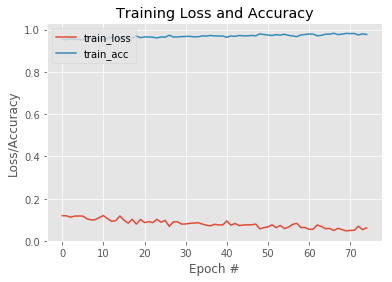

In [26]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
# plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig('plot.jpg')

# Testing

In [27]:
# Load images
test_image_paths = sorted(list(paths.list_images('./pose_dataset/test_set')))
random.seed(42)
random.shuffle(test_image_paths)
print(len(test_image_paths))

225


In [28]:
test_data = []
test_labels = []

# loop over the input images
for test_image_path in test_image_paths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(test_image_path)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    test_data.append(image)

    # extract set of class labels from the image path and update the
    # labels list
    l = label = test_image_path.split(os.path.sep)[-2].split("_")
    test_labels.append(l)
    
# scale the raw pixel intensities to the range [0, 1]
test_data = np.array(test_data, dtype="float") / 255.0
test_labels = np.array(test_labels)
print("[INFO] data matrix: {} images ({:.2f}MB)".format(
    len(test_image_paths), test_data.nbytes / (1024 * 1000.0)))

# binarize the labels using scikit-learn's special multi-label
# binarizer implementation
print("[INFO] class labels:")
test_mlb = MultiLabelBinarizer()
test_labels = test_mlb.fit_transform(test_labels)

# loop over each of the possible class labels and show them
for (i, label) in enumerate(test_mlb.classes_):
    print("{}. {}".format(i + 1, label))
    
print_label_details(test_labels)

[INFO] data matrix: 225 images (264.60MB)
[INFO] class labels:
1. bending
2. crouching
3. h
4. n
5. others
6. standing
225
bending: 60
crouching: 45
_h: 111
_n: 114 
others: 60
standing: 60


In [29]:
from keras.models import load_model

# construct the image generator
test_generator = ImageDataGenerator().flow(test_data, test_labels, batch_size=BS)
steps_test = test_generator.n / BS

# load model
_model = load_model('pose_multi_labels_mobilenet_v2.h5')

# evaluate model
print(_model.evaluate_generator(test_generator, steps=steps_test))

[1.0196504008769989, 0.8244444500075446]


In [23]:
# Predict the classes for all images in the test-set.
y_pred = _model.predict_generator(test_generator,
                                 steps=steps_test)
print(y_pred)

[[5.0181800e-08 9.9944192e-01 8.3210416e-08 9.9999988e-01 5.8943152e-07
  5.0987401e-06]
 [1.0257585e-08 9.9999988e-01 2.1627001e-07 9.9999976e-01 2.6392909e-08
  1.3264991e-15]
 [3.0543438e-07 7.6557021e-04 5.5257449e-10 1.0000000e+00 2.7301605e-03
  1.2689771e-01]
 ...
 [2.2598561e-09 9.8103011e-01 1.6980178e-10 1.0000000e+00 9.7129755e-03
  1.1990817e-07]
 [4.3433843e-09 9.9999940e-01 5.0678438e-05 9.9993658e-01 9.9248119e-08
  1.4165379e-10]
 [1.5266800e-04 2.7636532e-03 4.5758071e-07 9.9999952e-01 7.4092376e-01
  1.0124678e-06]]
